# **Yoga Pose Detection Using Deep Learning:**

## **Project Overview**
This project focuses on developing a deep learning model to classify images into different yoga poses. Yoga, known for its benefits in enhancing flexibility, strength, and mental well-being, includes various poses with specific benefits. With the advancement of technology, smart solutions can be implemented to assist and guide individuals in correctly performing yoga poses. This project aims to leverage such technology to classify images into yoga poses like the downward dog, goddess, tree, plank, and warrior poses.

## **Dataset**
The dataset used in this project is the "Yoga Poses Dataset" available on Kaggle, which can be accessed [here](https://www.kaggle.com/datasets/niharika41298/yoga-poses-dataset/data). This dataset consists of images categorized into five classes, representing different yoga poses. These images are extracted using the Bing API, and therefore, some may contain watermarks or text. The dataset is divided into training and testing subsets, each containing subfolders for the five classes of yoga poses.

## **Approach**
The project is structured into multiple stages:

**1. Data Preparation:** Loading the dataset, pre-processing the images, and setting up data augmentation techniques for robust training.

**2. Model Building:** Constructing a convolutional neural network (CNN) using transfer learning from the Xception model.

**3. Model Training and Validation:** Compiling and training the model on the dataset, along with validating its performance.

**4. Model Evaluation:** Assessing the trained model's accuracy and loss on the test dataset.

**5. Results and Visualization:** Visualizing the training process and performance metrics, and saving the trained model for future use.

Through this project, we aim to create a model that accurately identifies and classifies yoga poses, providing a foundation for developing applications that can guide users in their yoga practices.

# **Step 1. Data Preparation**
This part will include loading the dataset, pre-processing the images to ensure they're in a uniform format suitable for input into a neural network, and setting up data augmentation to enhance the diversity of the training data. Augmentation techniques like flipping, zooming, or rotating the images help in improving the model's ability to generalize. Additionally, this step includes removing any corrupted images and setting up data generators that will supply batches of images and labels during the training and validation phases.

In [ ]:
# Mount Google Drive with Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from PIL import Image, ImageFile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Preventing errors with truncated images
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Function to remove corrupted images
def removeCorruptedImages(path):
    for filename in os.listdir(path):
        try:
            img = Image.open(os.path.join(path,filename))
            img.verify()
        except (IOError, SyntaxError) as e:
            print('Bad file:', filename)
            os.remove(os.path.join(path,filename))

In [ ]:
import os
from PIL import Image

def removeCorruptedImages(directory):
    if not os.path.exists(directory):
        print(f"Directory does not exist: {directory}")
        return

    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            img = Image.open(filepath)
            img.verify()  # Verify that it is an image
        except (IOError, SyntaxError) as e:
            print(f"Removing corrupted image: {filepath}")
            os.remove(filepath)

basedir = "/content/drive/MyDrive/Yoga_Pose_Prediction/DATASET"
traindir = os.path.join(basedir, 'TRAIN')
validdir = os.path.join(basedir, 'TEST')

classes = ['downdog', 'goddess', 'plank', 'tree', 'warrior2']

for cls in classes:
    train_class_dir = os.path.join(traindir, cls)
    valid_class_dir = os.path.join(validdir, cls)
    removeCorruptedImages(train_class_dir)
    removeCorruptedImages(valid_class_dir)


In [ ]:
# Preparing Data Generators
train_datagen = ImageDataGenerator(rescale = 1./255, shear_range = 0.2, zoom_range = 0.2, horizontal_flip = True)
test_datagen = ImageDataGenerator(rescale = 1./255)

bx = 16

train_generator = train_datagen.flow_from_directory(traindir, target_size = (300, 300), batch_size = bx, class_mode = 'categorical')
valid_generator = test_datagen.flow_from_directory(validdir, target_size = (300, 300), batch_size = bx, class_mode = 'categorical')

Found 1081 images belonging to 5 classes.
Found 480 images belonging to 5 classes.


# **Step 2. Model Building**
This part is where you construct your neural network. This typically involves selecting a base model, such as a pre-trained network like Xception, and customizing it by adding layers tailored to the specific task of yoga pose detection. The architecture is finalized with an output layer designed to classify the number of yoga poses we're focusing on.

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Flatten, Dense, Activation, Dropout
from tensorflow.keras.applications import Xception

# Building the model
base_model = Xception(weights = '/content/drive/MyDrive/Yoga_Pose_Prediction/xception_weights_tf_dim_ordering_tf_kernels_notop.h5',
                      include_top = False,
                      input_shape = (300, 300, 3))

model = Sequential([
    Flatten(input_shape = base_model.output_shape[1:]),
    Dense(128, activation = 'relu'),
    Dropout(0.2),
    Dense(5, activation = 'softmax')
])

model = Model(inputs = base_model.input, outputs = model(base_model.output))

# **Step 3. Model Training and Validation**
This section involves compiling the model with appropriate loss functions, optimizers, and metrics, then training it using the prepared data. Concurrent validation ensures the model is learning effectively and not just memorizing the training data, a common problem known as overfitting.

In [ ]:
# Compiling the model
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate = 0.0001, momentum = 0.9, nesterov = True),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2, from_logits = True),
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300, 300, 3)]        0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 block1_conv1_bn (BatchNorm  (None, 149, 149, 32)         128       ['block1_conv1[0][0]']        
 alization)                                                                                       
                                                                                                  
 block1_conv1_act (Activati  (None, 149, 149, 32)         0         ['block1_conv1_bn[0][0]'] 

In [ ]:
# Training the model
hist = model.fit(train_generator, validation_data = valid_generator, epochs = 10)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


68/68 [==============================] - 140s 2s/step - loss: 1.2821 - accuracy: 0.5772 - val_loss: 0.9353 - val_accuracy: 0.8583
Epoch 2/10
68/68 [==============================] - 57s 835ms/step - loss: 0.9963 - accuracy: 0.8233 - val_loss: 0.8709 - val_accuracy: 0.9042
Epoch 3/10
68/68 [==============================] - 56s 828ms/step - loss: 0.9214 - accuracy: 0.8733 - val_loss: 0.8262 - val_accuracy: 0.9458
Epoch 4/10
68/68 [==============================] - 56s 816ms/step - loss: 0.8686 - accuracy: 0.9167 - val_loss: 0.8112 - val_accuracy: 0.9396
Epoch 5/10
68/68 [==============================] - 65s 965ms/step - loss: 0.8401 - accuracy: 0.9389 - val_loss: 0.8116 - val_accuracy: 0.9479
Epoch 6/10
68/68 [==============================] - 57s 840ms/step - loss: 0.8164 - accuracy: 0.9565 - val_loss: 0.7959 - val_accuracy: 0.9521
Epoch 7/10
68/68 [==============================] - 58s 845ms/step - loss: 0.8032 - accuracy: 0.9547 - val_loss: 0.7958 - val_accuracy: 0.9500
Epoch 8/10
6

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# **Step 4. Model Evaluation**
This part will assess the performance of the trained model using the test dataset. This is crucial for understanding how well the model performs on unseen data. Performance metrics such as accuracy, precision, and recall offer insights into the model's effectiveness.

In [ ]:
# Evaluating the model
val_loss, val_accuracy = model.evaluate(valid_generator)
print(f'Validation loss: {val_loss}')
print(f'Validation accuracy: {val_accuracy}')

30/30 [==============================] - 11s 376ms/step - loss: 0.7829 - accuracy: 0.9583
Validation loss: 0.7829359769821167
Validation accuracy: 0.9583333134651184


# **Step 5. Results and Visualization**
Finally, this section involves visualizing the training and validation loss and accuracy, interpreting these results to understand the model's learning behavior, and saving the trained model. This saved model can then be deployed or reused for future yoga pose detection without the need for retraining, making it a practical tool for real-world applications.

In [ ]:
# Saving the model
model.save("/content/drive/MyDrive/YOGA_POSE_DETECTION/TRAINED_MODEL/Yoga_Pose_Classification_Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


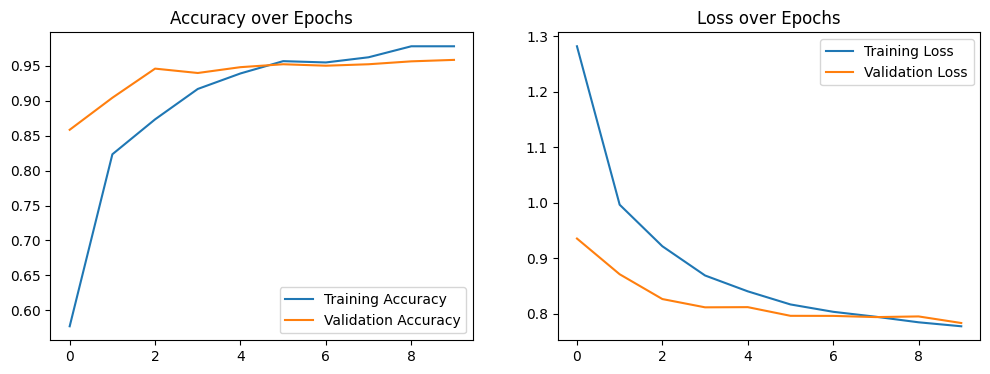

In [ ]:
# Visualizing training results
plt.figure(figsize = (12, 4))
plt.subplot(1, 2, 1)
plt.plot(hist.history['accuracy'], label = 'Training Accuracy')
plt.plot(hist.history['val_accuracy'], label = 'Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'], label = 'Training Loss')
plt.plot(hist.history['val_loss'], label = 'Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.show()

# **THE END**